In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, BatchNormalization
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
#tf.__version__
#tf.keras.__version__
#pd.__version__

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
## READ DATA ##
import dataprep.dataset as dataset
dataset_dir = '/data/fermilab-accelerator-ai/'
filename = 'MLParamData_1583906408.4261804_From_MLrn_2020-03-10+00_00_00_to_2020-03-11+00_00_00.h5_processed.csv.gz'
df = dataset.load_data(dataset_dir+filename)
print(df.shape)
print(df.head(2))

(1225585, 15)
                      time   B:ACMNPG    B:GMPS4V  B:IMINER   B:LINFRQ  \
0  2020-03-10 05:00:00.048  10.000006  123.134498 -0.270313  26.063342   
1  2020-03-10 05:00:00.114  10.000006  119.234494 -0.305312  26.008777   

      B:VIMAX     B:VIMIN  B:VINHBT  B:VIPHAS   B_ACMNPG     B_VIMIN  \
0  966.083496  103.379570       1.0  1.811700  10.000006  103.393158   
1  966.073730  103.421227       1.0  1.812469  10.000006  103.393158   

   B_VINHBT       I:IB     I:MDAT40       I:MXIB  
0       1.0  7055.9375  6977.386446  6974.145508  
1       1.0  7017.1875  6261.596654  6250.284180  


In [3]:
# columns of interest
source_variables = ['time','B:VIMIN','B:ACMNPG','B:LINFRQ','B:VIMAX','B_VIMIN','B:IMINER']#, 'B_VIMIN','B:IMINER']
# Extract data we're focused on
source_df = df[source_variables]
print(source_df.head())
print(source_df.shape)

                      time     B:VIMIN   B:ACMNPG   B:LINFRQ     B:VIMAX  \
0  2020-03-10 05:00:00.048  103.379570  10.000006  26.063342  966.083496   
1  2020-03-10 05:00:00.114  103.421227  10.000006  26.008777  966.073730   
2  2020-03-10 05:00:00.180  103.425453  10.000006  26.081531  966.037720   
3  2020-03-10 05:00:00.246  103.420357  10.000006  26.208850  966.054077   
4  2020-03-10 05:00:00.312  103.412270  10.000006  26.208850  966.031189   

      B_VIMIN  B:IMINER  
0  103.393158 -0.270313  
1  103.393158 -0.305312  
2  103.393158 -0.260313  
3  103.393158 -0.185312  
4  103.393158 -0.095312  
(1225585, 7)


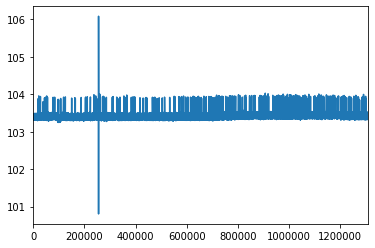

In [4]:
source_df['B:VIMIN'].plot()

In [5]:
shift_steps = 1
target_variables = ['B:VIMIN']
df_targets = source_df[target_variables].shift(-shift_steps)

In [6]:
source_df[target_variables].head(shift_steps + 5)

,B:VIMIN
0,103.379570
1,103.421227
2,103.425453
3,103.420357
4,103.412270
5,103.403305


In [7]:
df_targets.head(5)

,B:VIMIN
0,103.421227
1,103.425453
2,103.420357
3,103.412270
4,103.403305


In [8]:
x_data = source_df[source_variables][0:-shift_steps]
del x_data['time']
print(type(x_data))
print("Shape:", x_data.shape)
print((x_data.head()))
#print((x_data[0]))

<class 'pandas.core.frame.DataFrame'>
Shape: (1225584, 6)
      B:VIMIN   B:ACMNPG   B:LINFRQ     B:VIMAX     B_VIMIN  B:IMINER
0  103.379570  10.000006  26.063342  966.083496  103.393158 -0.270313
1  103.421227  10.000006  26.008777  966.073730  103.393158 -0.305312
2  103.425453  10.000006  26.081531  966.037720  103.393158 -0.260313
3  103.420357  10.000006  26.208850  966.054077  103.393158 -0.185312
4  103.412270  10.000006  26.208850  966.031189  103.393158 -0.095312


In [9]:
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)
print((y_data[0]))

<class 'numpy.ndarray'>
Shape: (1225584, 1)
[103.4212265]


In [10]:
num_data = len(x_data)
num_data

1225584

In [11]:
train_split = 0.9
num_train = int(train_split * num_data)
num_train

1103025

In [12]:
num_test = num_data - num_train
num_test

122559

In [13]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

1225584

In [14]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

1225584

In [15]:
num_x_signals = x_data.shape[1]
num_x_signals

6

In [16]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [17]:
print(x_train)

            B:VIMIN   B:ACMNPG   B:LINFRQ     B:VIMAX     B_VIMIN  B:IMINER
0        103.379570  10.000006  26.063342  966.083496  103.393158 -0.270313
1        103.421227  10.000006  26.008777  966.073730  103.393158 -0.305312
2        103.425453  10.000006  26.081531  966.037720  103.393158 -0.260313
3        103.420357  10.000006  26.208850  966.054077  103.393158 -0.185312
4        103.412270  10.000006  26.208850  966.031189  103.393158 -0.095312
...             ...        ...        ...         ...         ...       ...
1177987  103.478264  10.000006  -7.271588  966.024597  103.439636 -0.370312
1177988  103.465950  10.000006  -7.307965  966.027893  103.439636 -0.260313
1177989  103.454834  10.000006  -7.421643  966.027893  103.439636 -0.150312
1177990  103.440147  10.000006  -7.371625  966.031189  103.439636 -0.010313
1177991  103.434395  10.000006  -7.376172  966.040955  103.439636  0.054688

[1103025 rows x 6 columns]


In [18]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.fit_transform(x_test)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [19]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print("Min:", np.min(y_train_scaled))
print("Max:", np.max(y_train_scaled))

Min: 0.0
Max: 1.0


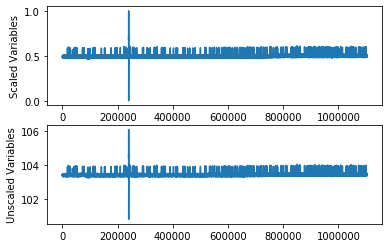

In [20]:
import matplotlib.pyplot as plt
# plot a line, implicitly creating a subplot(111)
plt.plot([1,2,3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
plt.subplot(211)
plt.ylabel('Scaled Variables')
plt.plot(y_train_scaled)

plt.subplot(212) # creates 2nd subplot with yellow background
plt.ylabel('Unscaled Variables')
plt.plot(y_scaler.inverse_transform(y_train_scaled))



In [21]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [22]:
batch_size = 256

In [23]:
sequence_length = 3*(15) ## 60 seconds - super cycle
sequence_length

45

In [24]:
generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)

In [25]:
x_batch, y_batch = next(generator)

In [26]:
print(x_batch.shape)
print(y_batch.shape)

(256, 45, 6)
(256, 45, 1)


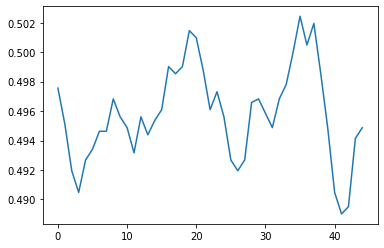

In [27]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

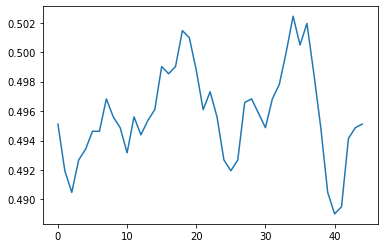

In [28]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [29]:
validation_data = (x_batch, y_batch)

In [30]:
model = Sequential()
model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(BatchNormalization())
model.add(Dense(num_y_signals, activation='tanh'))
from keras.optimizers import  SGD, Adam
opt = Adam(lr=0.001)
model.compile(loss='mse', optimizer=opt)
model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 512)         1062912   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 512)         2048      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 1,065,473
Trainable params: 1,064,449
Non-trainable params: 1,024
_________________________________________________________________


In [31]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

In [32]:
%%time
history = model.fit_generator(generator=generator,
                    epochs=10,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=[reduce_lr,early_stopping],
                    verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
 - 5s - loss: 0.1601 - val_loss: 2.1488
Epoch 2/10
 - 3s - loss: 0.0200 - val_loss: 2.2094
Epoch 3/10
 - 3s - loss: 6.1539e-04 - val_loss: 1.9323
Epoch 4/10
 - 3s - loss: 1.8501e-04 - val_loss: 1.3032
Epoch 5/10
 - 3s - loss: 1.2339e-04 - val_loss: 0.6978
Epoch 6/10
 - 3s - loss: 8.4305e-05 - val_loss: 0.3484
Epoch 7/10
 - 3s - loss: 6.4056e-05 - val_loss: 0.1816
Epoch 8/10
 - 3s - loss: 4.8313e-05 - val_loss: 0.0979
Epoch 9/10
 - 3s - loss: 4.2270e-05 - val_loss: 0.0586
Epoch 10/10
 - 3s - loss: 3.3419e-05 - val_loss: 0.0363
CPU times: user 41.2 s, sys: 2.81 s, total: 44 s
Wall time: 33.9 s


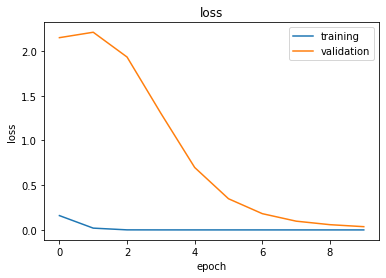

In [33]:
##############
# SAVE PLOTS #
##############
def makePlots(history, figname_prefix='', withval=True):
    figname=figname_prefix

    #training, validation, and test loss
    plt.plot(history.history['loss'])
    if withval:
        plt.plot(history.history['val_loss'])
    #plt.scatter(epochs-1,test_loss)
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

    #plt.savefig(figname+'lossplot.png')
    #plt.close()

makePlots(history)